# Mooomentums
Mooom is a strategy that heavily relies on momentum. It enriches dataframe with simple momentum and industrial momentum factors. Returns will be substracted by a cross-sectional median.

In [198]:
from functools import reduce
import numpy as np
import pandas as pd
from pandas.tseries.offsets import DateOffset
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from ta import add_all_ta_features
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.options.mode.chained_assignment = None
np.seterr(divide="ignore", invalid="ignore")
import warnings
warnings.filterwarnings('ignore')

In [194]:
df = pd.read_parquet("../data/compustat_ibes_raw_alpha.1.parquet")

In [196]:
def conf(clf, X_test, y_test):
    f, ax = plt.subplots(figsize=(4.8, 4.8))
    y_test_pred = clf.predict(X_test)
    conf_mat = confusion_matrix(y_test, y_test_pred)
    conf_ax = sns.heatmap(
        conf_mat, ax=ax, annot=True, fmt="", cmap=plt.cm.Blues, cbar=False
    )
    conf_ax.set_xlabel("Predicted")
    conf_ax.set_ylabel("True")

In [3]:
def extreme(df):
    """Retain the 20% values that are the smallest and the 20% that are the largest."""
    top = df.y.quantile(0.8)
    low = df.y.quantile(0.2)
    return df[(df.y < low) | (df.y > top)]

In [170]:
def mooom(df):
    """
    Mooom is a strategy that heavily relies on momentum.
    It enriches dataframe with simple momentum and industrial momentum factors. 
    Returns will be substracted by a cross-sectional median.
    """
    df_mom = df[["classification",
                 "mcap",
                 "act",
                 "ceq",
                 "cogs",
                 "lct",
                 "nicon",
                 "revt",
                 "xrd",
                 "prccd",
                 "close"]]
    df_mom["profitability_roe"]=df_mom.nicon / df_mom.ceq
    df_mom["intangible_rdm"] = df_mom.xrd / df_mom.mcap
    df_mom["liquid_cur"] = df_mom.act / df_mom.lct
    df_mom["market_pe"] = df_mom.mcap / (df_mom.nicon * 10 ** 6)
    df_mom["market_mb"] = df_mom.mcap / (df_mom.ceq * 10 ** 6)
    df_mom["52wk_high"] = df_mom.close.groupby("gvkey").transform(lambda x: np.log(x) - np.log(x.rolling(12, min_periods=1).max()))
    df_mom["mom_12m"] = df_mom.close.groupby("gvkey").transform(lambda x: np.log(x.shift(2))-np.log(x.shift(13)))
    df_mom["mom_6m"] = df_mom.close.groupby("gvkey").transform(lambda x: np.log(x).shift(2) - np.log(x.shift(7)))
    df_mom["mom_1m"] = df_mom.close.groupby("gvkey").transform(lambda x: np.log(x) - np.log(x.shift(1)))
    df_mom["ind_mom_12m"] = df_mom.groupby(["date", "classification"]).mom_12m.transform("mean")
    df_mom["ind_mom_6m"] = df_mom.groupby(["date", "classification"]).mom_6m.transform("mean")
    df_mom["ind_mom_1m"] = df_mom.groupby(["date", "classification"]).mom_1m.transform("mean")
    df_mom["log_return"] = df_mom.close.groupby("gvkey").transform(lambda x: np.log(x.shift(-3)) - np.log(x))
    df_mom["y"] = df_mom.groupby("date").log_return.transform(lambda x: (x - x.median()).clip(-1,1))
    return df_mom.loc[df.prccd > 5, ["mcap",
                                     "profitability_roe",
                                     "intangible_rdm",
                                     "liquid_cur",
                                     "market_mb",
                                     "market_pe",
                                     "52wk_high",
                                     "mom_12m",
                                     "mom_6m",
                                     "mom_1m",
                                     "ind_mom_12m",
                                     "ind_mom_6m",
                                     "ind_mom_1m",
                                     "y"]].dropna()

In [ ]:
df_mom = mooom(df)

## Regression

In [89]:
def r2(y_true, y_pred):
    r2 = 1 - np.sum((y_true - y_pred) ** 2)/np.sum(y_true ** 2)
    return r2

r2_score = make_scorer(r2)

In [171]:
df_train = df_mom.xs(slice("2002-01-01", "2012-01-01"), level="date", drop_level=False)
df_test = df_mom.xs(slice("2012-01-01", "2016-01-01"), level="date", drop_level=False)
X_train = df_train.drop(["y"], axis=1).to_numpy()
y_train = df_train["y"].to_numpy()
X_test = df_test.drop(["y"], axis=1).to_numpy()
y_test = df_test["y"].to_numpy()

In [172]:
xgb_reg = XGBRegressor(n_estimators=100, max_depth=3, n_jobs=-1)
xgb_fit = xgb_reg.fit(X_train, y_train)
train_score = r2_score(xgb_reg, X_train, y_train)
test_score = r2_score(xgb_reg, X_test, y_test)
print(f"R2 on training set: {train_score}\nR2 on test set: {test_score}")

R2 on training set: 0.08926540338353117
R2 on test set: 0.027067763216712337


## Binary Classification

In [204]:
df_train = df_mom.xs(slice("2002-01-01", "2012-01-01"), level="date", drop_level=False)
df_test = df_mom.xs(slice("2012-01-01", "2016-01-01"), level="date", drop_level=False)
X_train = df_train.drop(["y"], axis=1).to_numpy()
y_train = np.where(df_train.y > 0, 0, 1)
X_test = df_test.drop(["y"], axis=1).to_numpy()
y_test = np.where(df_test.y > 0, 0, 1)

Accuracy on training set: 0.5890400202413255
Accuracy on test set: 0.5606404113591212
              precision    recall  f1-score   support

        sell       0.57      0.70      0.63     22788
         buy       0.54      0.40      0.46     19997

    accuracy                           0.56     42785
   macro avg       0.56      0.55      0.55     42785
weighted avg       0.56      0.56      0.55     42785



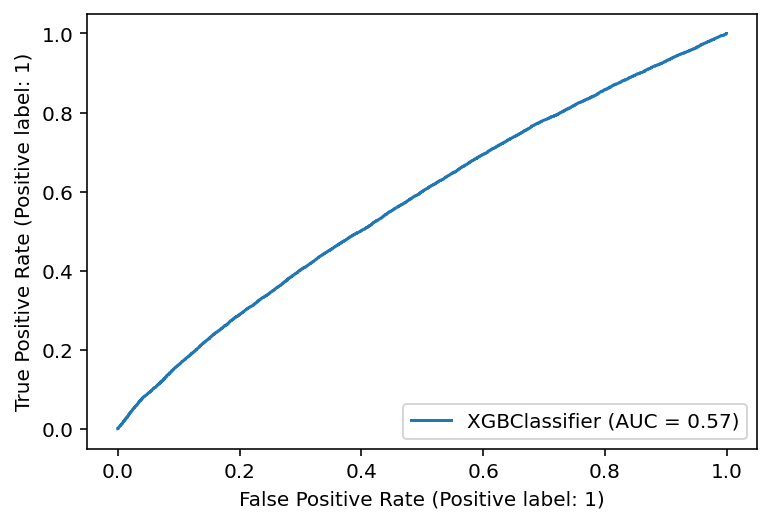

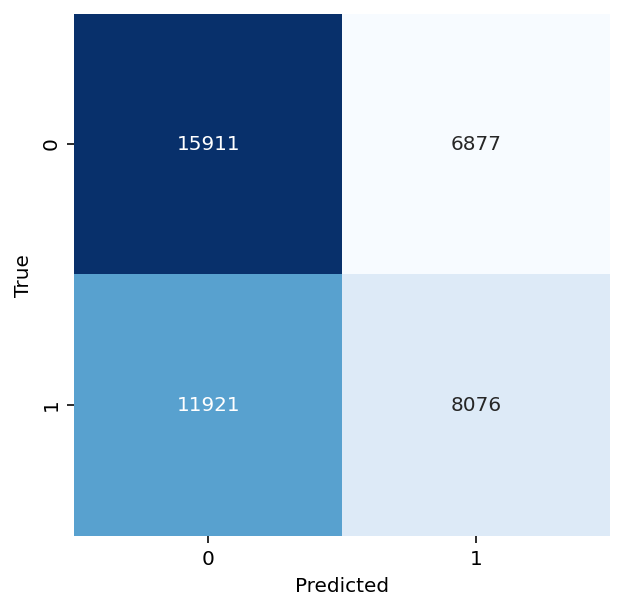

In [205]:
xgb_clf = XGBClassifier(n_estimators=100, max_depth=3, eval_metric='logloss', n_jobs=-1)
xgb_fit = xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)
train_score = accuracy_score(y_train, xgb_clf.predict(X_train))
test_score = accuracy_score(y_test, y_pred)
plot_roc_curve(xgb_clf, X_test, y_test)
conf(xgb_clf, X_test, y_test)
print(f"Accuracy on training set: {train_score}\nAccuracy on test set: {test_score}")
print(classification_report(y_test, y_pred, target_names=["sell", "buy"]))

## Multi Classification

In [190]:
def threshold(y):
    thres = 0.1
    y_0 = np.where(y < -thres, -1, y)
    y_1 = np.where((y <= thres) & (y >= -thres), 0, y_0)
    y_2 = np.where(y > thres, 1, y_1)
    return y_2

In [202]:
df_train = df_mom.xs(slice("2002-01-01", "2012-01-01"), level="date", drop_level=False).groupby("date").apply(extreme)
df_test = df_mom.xs(slice("2012-01-01", "2016-01-01"), level="date", drop_level=False)
X_train = df_train.drop(["y"], axis=1).to_numpy()
y_train= threshold(df_train.y)
X_test = df_test.drop(["y"], axis=1).to_numpy()
y_test= threshold(df_test.y)

Accuracy on training set: 0.599542234332425
Accuracy on test set: 0.2277667406801449
              precision    recall  f1-score   support

        sell       0.24      0.47      0.32      7102
        hold       0.00      0.00      0.00     26866
         buy       0.22      0.72      0.34      8817

    accuracy                           0.23     42785
   macro avg       0.15      0.40      0.22     42785
weighted avg       0.09      0.23      0.12     42785



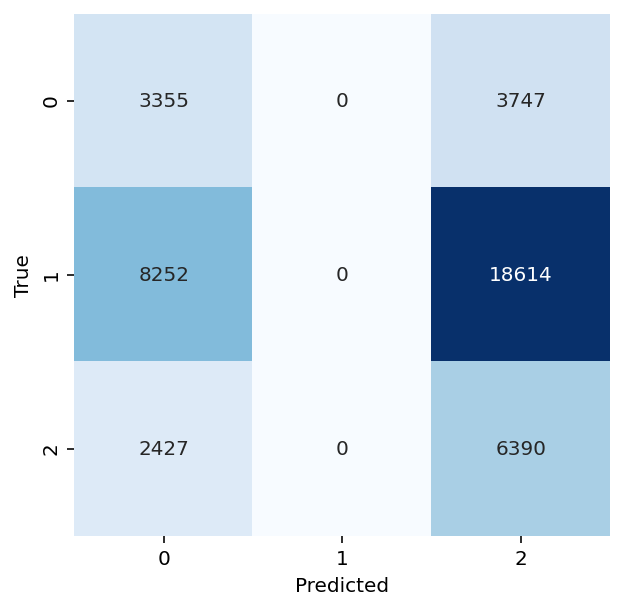

In [203]:
xgb_clf = XGBClassifier(n_estimators=100, max_depth=3, eval_metric='logloss', n_jobs=-1)
xgb_fit = xgb_clf.fit(X_train, y_train)
y_pred= xgb_clf.predict(X_test)
train_score = accuracy_score(y_train, xgb_clf.predict(X_train))
test_score = accuracy_score(y_test, y_pred)
conf(xgb_clf, X_test, y_test)
print(f"Accuracy on training set: {train_score}\nAccuracy on test set: {test_score}")
print(classification_report(y_test, y_pred, target_names=["sell", "hold", "buy"]))

## Portfolio Return

In [154]:
# backtest
# every stock invest 1
# every month invest 100 predicted best performing stocks
# collect return 3 month after
# y_position = y_pred.grouby("date").head(10)
# y_return = y_position * y_test

In [209]:
df_train = df_mom.xs(slice("2002-01-01", "2012-01-01"), level="date", drop_level=False).groupby("date").apply(extreme)
df_test = df_mom.xs(slice("2012-01-01", "2016-01-01"), level="date", drop_level=False)
X_train = df_train.drop(["y"], axis=1).to_numpy()
y_train= threshold(df_train.y)
X_test = df_test.drop(["y"], axis=1).to_numpy()
y_test = threshold(df_test.y)
xgb_clf = XGBClassifier(n_estimators=100, max_depth=3, eval_metric='logloss', n_jobs=-1)
xgb_fit = xgb_clf.fit(X_train, y_train)
y_pred= xgb_clf.predict(X_test)
train_score = accuracy_score(y_train, xgb_clf.predict(X_train))
test_score = accuracy_score(y_test, y_pred)
print(f"Accuracy on training set: {train_score}\nAccuracy on test set: {test_score}")
print(classification_report(y_test, y_pred, target_names=["sell", "hold", "buy"]))

Accuracy on training set: 0.599542234332425
Accuracy on test set: 0.2277667406801449
              precision    recall  f1-score   support

        sell       0.24      0.47      0.32      7102
        hold       0.00      0.00      0.00     26866
         buy       0.22      0.72      0.34      8817

    accuracy                           0.23     42785
   macro avg       0.15      0.40      0.22     42785
weighted avg       0.09      0.23      0.12     42785



In [221]:
def frame_to_signal(frame, estimator):
    X = frame.drop(columns="y").to_numpy()
    long_signal = estimator.predict_proba(X)[:, -1]
    short_signal = estimator.predict_proba(X)[:, 0]
    return pd.DataFrame(data={"long_signal": long_signal, "short_signal": short_signal}, index=frame.index)

In [ ]:
def signal_to_position(signal, n, t):


In [228]:
frame_to_signal(df_1h, xgb_clf)

long_signal  short_signal
gvkey  date                                 
001166 2012-01-31     0.471982      0.476889
       2012-02-29     0.525388      0.407839
       2012-03-31     0.569609      0.367332
       2012-04-30     0.656575      0.303809
       2012-05-31     0.611049      0.336493
       2012-06-30     0.555476      0.382814
       2012-07-31     0.618864      0.311402
       2012-08-31     0.638155      0.314297
       2012-09-30     0.599405      0.358883
       2012-10-31     0.578631      0.383686
       2012-11-30     0.590039      0.349314
       2012-12-31     0.441720      0.456212
       2013-01-31     0.492387      0.403333
       2013-02-28     0.527441      0.382657
       2013-03-31     0.405098      0.524850
       2013-04-30     0.406579      0.530178
       2013-05-31     0.348879      0.549494
       2013-06-30     0.348697      0.570686
       2013-07-31     0.339704      0.587762
       2013-08-31     0.317366      0.604225
       2013-09-30     0.284890      0.638589
       2013-10-31     0.325098      0.601191
       2013-11-30     0.370167      0.546534
       2013-12-31     0.470585      0.441383
       2014-01-31     0.477934      0.410772
       2014-02-28     0.501009      0.385621
       2014-03-31     0.529759      0.327263
       2014-04-30     0.597175      0.267073
       2014-05-31     0.629418      0.220292
       2014-06-30     0.651983      0.225979
       2014-07-31     0.613629      0.276049
       2014-08-31     0.643204      0.227441
       2014-09-30     0.625558      0.244812
       2014-10-31     0.634355      0.261012
       2014-11-30     0.677691      0.227849
       2014-12-31     0.623271      0.285448
       2015-01-31     0.598847      0.294952
       2015-02-28     0.563141      0.330246
       2015-03-31     0.535567      0.344525
       2015-04-30     0.557270      0.338216
       2015-05-31     0.557105      0.337598
       2015-06-30     0.549951      0.343509
       2015-07-31     0.534369      0.353047
       2015-08-31     0.466684      0.479704
       2015-09-30     0.542348      0.413216
       2015-10-31     0.464491      0.471855
008546 2012-01-31     0.367804      0.599774
       2012-02-29     0.305487      0.642200
       2012-03-31     0.319937      0.624968
       2012-04-30     0.300264      0.617371
       2012-05-31     0.302543      0.644081
       2012-06-30     0.221208      0.662329
       2012-07-31     0.250880      0.593000
       2012-08-31     0.289405      0.497055
       2012-09-30     0.475421      0.276139
       2012-10-31     0.474757      0.307489
       2012-11-30     0.475384      0.288956
       2012-12-31     0.550488      0.245704
       2013-01-31     0.412069      0.336351
       2013-02-28     0.569790      0.253910
       2013-03-31     0.495898      0.294536
       2013-04-30     0.504874      0.310774
       2013-05-31     0.502021      0.306470
       2013-06-30     0.559536      0.301757
       2013-07-31     0.463522      0.358702
       2013-08-31     0.497386      0.272054
       2013-09-30     0.518478      0.274068
       2013-10-31     0.460671      0.343390
       2013-11-30     0.489637      0.255266
       2013-12-31     0.564052      0.290263
       2014-01-31     0.535493      0.264918
       2014-02-28     0.533242      0.292569
       2014-03-31     0.541002      0.278588
       2014-04-30     0.546598      0.338404
       2014-05-31     0.523714      0.311035
       2014-06-30     0.470718      0.382583
       2014-07-31     0.471490      0.384977
       2014-08-31     0.450074      0.405328
       2014-09-30     0.416045      0.441238
       2014-10-31     0.491752      0.437996
       2014-11-30     0.383287      0.492957
       2014-12-31     0.457923      0.468019
       2015-01-31     0.400785      0.452217
       2015-02-28     0.371678      0.444358
       2015-03-31     0.466295      0.331291
       2015-04-30     0.454907      0.342481
       2015-05-31     0.485315      0.271284
       2015-06

In [227]:
df_1h = df_test.head(100)
X = df_1h.drop(columns="y").to_numpy()
long_signal = xgb_clf.predict_proba(X)[:, -1]
short_signal = xgb_clf.predict_proba(X)[:, 0]
pd.DataFrame(data={"long_signal": long_signal, "short_signal": short_signal}, index=df_1h.index)

long_signal  short_signal
gvkey  date                                 
001166 2012-01-31     0.471982      0.476889
       2012-02-29     0.525388      0.407839
       2012-03-31     0.569609      0.367332
       2012-04-30     0.656575      0.303809
       2012-05-31     0.611049      0.336493
       2012-06-30     0.555476      0.382814
       2012-07-31     0.618864      0.311402
       2012-08-31     0.638155      0.314297
       2012-09-30     0.599405      0.358883
       2012-10-31     0.578631      0.383686
       2012-11-30     0.590039      0.349314
       2012-12-31     0.441720      0.456212
       2013-01-31     0.492387      0.403333
       2013-02-28     0.527441      0.382657
       2013-03-31     0.405098      0.524850
       2013-04-30     0.406579      0.530178
       2013-05-31     0.348879      0.549494
       2013-06-30     0.348697      0.570686
       2013-07-31     0.339704      0.587762
       2013-08-31     0.317366      0.604225
       2013-09-30     0.284890      0.638589
       2013-10-31     0.325098      0.601191
       2013-11-30     0.370167      0.546534
       2013-12-31     0.470585      0.441383
       2014-01-31     0.477934      0.410772
       2014-02-28     0.501009      0.385621
       2014-03-31     0.529759      0.327263
       2014-04-30     0.597175      0.267073
       2014-05-31     0.629418      0.220292
       2014-06-30     0.651983      0.225979
       2014-07-31     0.613629      0.276049
       2014-08-31     0.643204      0.227441
       2014-09-30     0.625558      0.244812
       2014-10-31     0.634355      0.261012
       2014-11-30     0.677691      0.227849
       2014-12-31     0.623271      0.285448
       2015-01-31     0.598847      0.294952
       2015-02-28     0.563141      0.330246
       2015-03-31     0.535567      0.344525
       2015-04-30     0.557270      0.338216
       2015-05-31     0.557105      0.337598
       2015-06-30     0.549951      0.343509
       2015-07-31     0.534369      0.353047
       2015-08-31     0.466684      0.479704
       2015-09-30     0.542348      0.413216
       2015-10-31     0.464491      0.471855
008546 2012-01-31     0.367804      0.599774
       2012-02-29     0.305487      0.642200
       2012-03-31     0.319937      0.624968
       2012-04-30     0.300264      0.617371
       2012-05-31     0.302543      0.644081
       2012-06-30     0.221208      0.662329
       2012-07-31     0.250880      0.593000
       2012-08-31     0.289405      0.497055
       2012-09-30     0.475421      0.276139
       2012-10-31     0.474757      0.307489
       2012-11-30     0.475384      0.288956
       2012-12-31     0.550488      0.245704
       2013-01-31     0.412069      0.336351
       2013-02-28     0.569790      0.253910
       2013-03-31     0.495898      0.294536
       2013-04-30     0.504874      0.310774
       2013-05-31     0.502021      0.306470
       2013-06-30     0.559536      0.301757
       2013-07-31     0.463522      0.358702
       2013-08-31     0.497386      0.272054
       2013-09-30     0.518478      0.274068
       2013-10-31     0.460671      0.343390
       2013-11-30     0.489637      0.255266
       2013-12-31     0.564052      0.290263
       2014-01-31     0.535493      0.264918
       2014-02-28     0.533242      0.292569
       2014-03-31     0.541002      0.278588
       2014-04-30     0.546598      0.338404
       2014-05-31     0.523714      0.311035
       2014-06-30     0.470718      0.382583
       2014-07-31     0.471490      0.384977
       2014-08-31     0.450074      0.405328
       2014-09-30     0.416045      0.441238
       2014-10-31     0.491752      0.437996
       2014-11-30     0.383287      0.492957
       2014-12-31     0.457923      0.468019
       2015-01-31     0.400785      0.452217
       2015-02-28     0.371678      0.444358
       2015-03-31     0.466295      0.331291
       2015-04-30     0.454907      0.342481
       2015-05-31     0.485315      0.271284
       2015-06

array([0.4719821 , 0.5253883 , 0.569609  , 0.6565752 , 0.61104935,
       0.55547595, 0.6188645 , 0.638155  , 0.5994046 , 0.5786305 ,
       0.59003943, 0.4417202 , 0.49238706, 0.52744067, 0.4050981 ,
       0.40657935, 0.3488795 , 0.3486968 , 0.3397037 , 0.31736603,
       0.28489015, 0.3250978 , 0.37016717, 0.47058544, 0.47793424,
       0.5010088 , 0.52975905, 0.59717494, 0.6294179 , 0.65198284,
       0.6136294 , 0.64320385, 0.62555796, 0.634355  , 0.67769104,
       0.62327105, 0.59884685, 0.56314117, 0.5355666 , 0.5572704 ,
       0.55710506, 0.54995096, 0.53436947, 0.4666844 , 0.54234827,
       0.46449134, 0.36780387, 0.3054874 , 0.319937  , 0.30026373,
       0.302543  , 0.2212078 , 0.2508803 , 0.28940544, 0.47542128,
       0.4747574 , 0.47538352, 0.5504875 , 0.41206935, 0.5697899 ,
       0.49589813, 0.5048739 , 0.5020209 , 0.5595356 , 0.46352232,
       0.49738595, 0.51847804, 0.46067086, 0.48963666, 0.5640519 ,
       0.5354931 , 0.53324175, 0.5410021 , 0.5465976 , 0.52371